# ALERT: RESTART THE KERNEL AFTER pip install umap-learn

In [ ]:
%%capture
!pip install transformers sentence_transformers seaborn umap-learn

# Choose from 1 of these models:
## <b>1) Spanish only models:</b>
### **_a/ Trained on Sentence Similarity task:_**
hiiamsid/sentence_similarity_spanish_es
### **_b/ Trained on other task:_**
pysentimiento/robertuito-sentiment-analysis
## <b>2) Multilingual models:</b>
### **_a/ Trained on Sentence Similarity task:_**
clips/mfaq

symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli

sentence-transformers/stsb-xlm-r-multilingual

sentence-transformers/paraphrase-multilingual-mpnet-base-v2

sentence-transformers/paraphrase-xlm-r-multilingual-v1

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
### **_b/ Trained on other task:_**
xlm-roberta-large

xlm-roberta-base

facebook/mbart-large-50


In [14]:
%%capture
# If you use the model trained in Sentence Similarity task, put True
# If you use the model trained in different task, put False
SIMILARITY_TRAINED = True

from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
model_name = 'hiiamsid/sentence_similarity_spanish_es'

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Train the model

In [166]:
from sentence_transformers import InputExample

if SIMILARITY_TRAINED:
  model = SentenceTransformer(model_name)
else:
  model = AutoModel.from_pretrained(model_name)

all_sports_sentences = ['La selección Colombia vence a Perú pero se queda sin mundial',
'Santa Fe gana el clásico capitalino 2 - 0 ante Millonarios',
'Mariana Pajón gana el mundial de bmx',
'El tour por Colombia comenzará en 3 semanas',
'Falcao se lesiona otra vez, esta vez estará 3 semanas de baja']

all_economics_sentences = ['El dólar se vuelve a disparar, ya se cotiza a $4.600',
'El ministro de Hacienda confirma que continuarán las exploraciones petroleras',
'Ministra de Minas afirma que consideraría importar gas de Venezuela',
'El presidente anuncia el corte al subsidio a la gasolina',
'El salario mínimo debe subir un 14%, anuncia el presidente'
]

all_environment_sentences = ['Un nuevo ecosistema recién descubierto es un “oásis de vida” en el océano Índico',
'Se requieren acciones “urgentes” para detener la deforestación para 2030',
'Nueva Zelanda intentará ponerle precio a los gases que producen las vacas',
'En fotos: así son los sabores de la selva amazónica',
'Deforestación en el Meta, la lucha por salvar los bosques amazónicos',]

sports_sentences = all_sports_sentences[:-2]
economics_sentences = all_economics_sentences[:-2]
environment_sentences = all_environment_sentences[:-2]

test_sports_sentences = all_sports_sentences[-2:]
test_economics_sentences = all_economics_sentences[-2:]
test_environment_sentences = all_environment_sentences[-2:]

test_sentences = [test_sports_sentences, test_economics_sentences, test_environment_sentences]

category_sentences = [sports_sentences, economics_sentences, environment_sentences]

train_examples = []
for cate_i in range(len(category_sentences)):
    for i in range(len(category_sentences[cate_i])-1):
        negative_sentences = category_sentences[(cate_i+1)%(len(category_sentences)-1)] + category_sentences[(cate_i+2)%(len(category_sentences)-1)]
        for j in range(len(negative_sentences)):
            train_examples.append(InputExample(texts=[category_sentences[cate_i][i], category_sentences[cate_i][i+1], negative_sentences[j]]))
len(train_examples)

36

# Before

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


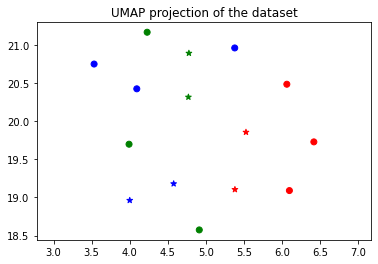

In [167]:
import torch
import numpy as np
import itertools
texts = list(itertools.chain(*category_sentences)) + list(itertools.chain(*test_sentences))
len_test_sentences = len(list(itertools.chain(*test_sentences)))
if SIMILARITY_TRAINED:
  embeddings = model.encode(texts)
else:
  tokens = tokenizer(texts)
  max_len = max([len(i) for i in tokens['input_ids']])
  tokens_input_ids_padded = [list(token_input_id) + [tokenizer.pad_token_id]*(max_len-len(token_input_id)) for token_input_id in tokens['input_ids']]
  attention_masks_padded = [list(attention_mask) + [0]*(max_len-len(attention_mask)) for attention_mask in tokens['attention_mask']]
  embeddings = model(torch.tensor(tokens_input_ids_padded, dtype=torch.long, device=torch.device('cpu')), \
                     attention_mask=torch.tensor(attention_masks_padded, dtype=torch.long, device=torch.device('cpu'))).last_hidden_state[:,0,:].detach().numpy()
import umap
reducer = umap.UMAP()
embed_2d = reducer.fit_transform(embeddings)
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embed_2d[:-len_test_sentences, 0],
    embed_2d[:-len_test_sentences, 1],
    c = ['r']*len(sports_sentences) + ['b']*len(economics_sentences) +['g']*len(environment_sentences),
    marker='o')
plt.scatter(
    embed_2d[-len_test_sentences:, 0],
    embed_2d[-len_test_sentences:, 1],
    c = ['r']*len(test_sports_sentences)+['b']*len(test_economics_sentences)+['g']*len(test_environment_sentences),
    marker='*')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset');

In [168]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
from sentence_transformers import losses
train_loss = losses.TripletLoss(model=model)
num_epochs = 10
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [169]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          optimizer_params={'lr': 5e-05}) 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

# After

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


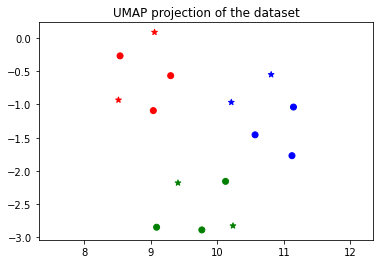

In [170]:
import torch
import numpy as np
import itertools
texts = list(itertools.chain(*category_sentences)) + list(itertools.chain(*test_sentences))
len_test_sentences = len(list(itertools.chain(*test_sentences)))
if SIMILARITY_TRAINED:
  embeddings = model.encode(texts)
else:
  tokens = tokenizer(texts)
  max_len = max([len(i) for i in tokens['input_ids']])
  tokens_input_ids_padded = [list(token_input_id) + [tokenizer.pad_token_id]*(max_len-len(token_input_id)) for token_input_id in tokens['input_ids']]
  attention_masks_padded = [list(attention_mask) + [0]*(max_len-len(attention_mask)) for attention_mask in tokens['attention_mask']]
  embeddings = model(torch.tensor(tokens_input_ids_padded, dtype=torch.long, device=torch.device('cpu')), \
                     attention_mask=torch.tensor(attention_masks_padded, dtype=torch.long, device=torch.device('cpu'))).last_hidden_state[:,0,:].detach().numpy()
import umap
reducer = umap.UMAP()
embed_2d = reducer.fit_transform(embeddings)
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embed_2d[:-len_test_sentences, 0],
    embed_2d[:-len_test_sentences, 1],
    c = ['r']*len(sports_sentences) + ['b']*len(economics_sentences) +['g']*len(environment_sentences),
    marker='o')
plt.scatter(
    embed_2d[-len_test_sentences:, 0],
    embed_2d[-len_test_sentences:, 1],
    c = ['r']*len(test_sports_sentences)+['b']*len(test_economics_sentences)+['g']*len(test_environment_sentences),
    marker='*')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset');